In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

from collections import defaultdict

In [2]:
# === Load and preprocess files ===
folder_path = 'Data'  # <-- CHANGE THIS
files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.txt')])

X_flattened = []
X_raw_3D = []
valid_files = []
misaligned_files = []

for file in files:
    df = pd.read_csv(file, sep='\t')
    df_numeric = df.apply(pd.to_numeric, errors='coerce').interpolate(method='linear', limit_direction='both')

    if df_numeric.shape != (1000, 13):
        misaligned_files.append(os.path.basename(file))
        continue

    # Flattened (for PCA, KMeans, DBSCAN)
    X_flattened.append(df_numeric.values.flatten())
    # Raw 3D (for DTW clustering)
    X_raw_3D.append(df_numeric.values)
    valid_files.append(os.path.basename(file))

In [5]:
X_flattened = np.array(X_flattened)
X_raw_3D = np.array(X_raw_3D)  # shape: (98, 1000, 13)

# === Standardize flattened data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flattened)

# === PCA to retain 95% variance ===
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [6]:
# === Clustering methods ===
results = {}

# Method 1: KMeans (Original)
results["KMeans"] = KMeans(n_clusters=2, random_state=42).fit_predict(X_scaled)

# Method 2: PCA + KMeans
results["PCA_KMeans"] = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Method 3: DTW + KMeans (tslearn)
ts_kmeans = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=10, random_state=42)
X_ts = to_time_series_dataset(X_raw_3D)
results["DTW_KMeans"] = ts_kmeans.fit_predict(X_ts)

# Method 4: Hierarchical Clustering (Ward linkage)
Z = linkage(X_scaled, method='ward')
results["Hierarchical"] = fcluster(Z, t=2, criterion='maxclust') - 1  # 0/1

# Method 5: DBSCAN (may produce -1 for outliers)
results["DBSCAN"] = DBSCAN(eps=3.0, min_samples=3).fit_predict(X_scaled)

c:\Users\Shibin\miniconda3\envs\PAS\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Shibin\miniconda3\envs\PAS\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:
# === Summary Table ===
print("\n📊 Cluster Assignment Summary (First 10 Files)")
print(f"{'Filename':<30} {'KMeans':>7} {'PCA':>7} {'DTW':>7} {'Hier':>7} {'DBSCAN':>8}")
print("-" * 70)
for i in range(min(50, len(valid_files))):
    row = f"{valid_files[i]:<30}"
    for method in results:
        row += f"{results[method][i]:>7}"
    print(row)


📊 Cluster Assignment Summary (First 10 Files)
Filename                        KMeans     PCA     DTW    Hier   DBSCAN
----------------------------------------------------------------------
file_14894.txt                      1      0      0      0     -1
file_15229.txt                      0      0      0      1     -1
file_15576.txt                      0      0      0      1     -1
file_16361.txt                      0      0      0      1     -1
file_17860.txt                      1      0      0      0     -1
file_18883.txt                      1      0      0      0     -1
file_20658.txt                      0      0      0      1     -1
file_20726.txt                      0      0      0      1     -1
file_20785.txt                      0      0      0      1     -1
file_22059.txt                      1      0      0      0     -1
file_22620.txt                      0      1      1      1     -1
file_22636.txt                      0      1      1      1     -1
file_2345.txt     

In [8]:
# === Cluster Counts and File Lists ===
print("\n📦 Cluster Counts & Filenames:")
cluster_files = defaultdict(lambda: defaultdict(list))

for method, labels in results.items():
    print(f"\n🔸 {method}")
    unique, counts = np.unique(labels, return_counts=True)
    for u, c in zip(unique, counts):
        cluster_files[method][u] = [valid_files[i] for i in range(len(labels)) if labels[i] == u]
        print(f"  Cluster {u}: {c} files")


📦 Cluster Counts & Filenames:

🔸 KMeans
  Cluster 0: 49 files
  Cluster 1: 49 files

🔸 PCA_KMeans
  Cluster 0: 91 files
  Cluster 1: 7 files

🔸 DTW_KMeans
  Cluster 0: 91 files
  Cluster 1: 7 files

🔸 Hierarchical
  Cluster 0: 46 files
  Cluster 1: 52 files

🔸 DBSCAN
  Cluster -1: 98 files



⚠️ Misaligned files skipped: 0


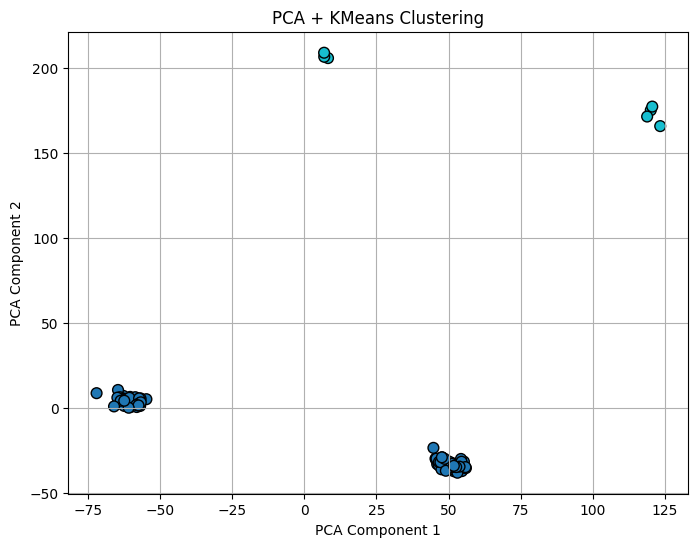

In [9]:
# === Misaligned files ===
print(f"\n⚠️ Misaligned files skipped: {len(misaligned_files)}")
if misaligned_files:
    print("  " + "\n  ".join(misaligned_files))

# === Optional: Plotting PCA + KMeans only ===
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=results["PCA_KMeans"], cmap='tab10', edgecolor='k', s=60)
plt.title('PCA + KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

Error processing file file_550.txt: Some errors were detected !
    Line #3 (got 13 columns instead of 12)
    Line #4 (got 13 columns instead of 12)
    Line #5 (got 13 columns instead of 12)
    Line #6 (got 13 columns instead of 12)
    Line #7 (got 13 columns instead of 12)
    Line #8 (got 13 columns instead of 12)
    Line #9 (got 13 columns instead of 12)
    Line #10 (got 13 columns instead of 12)
    Line #11 (got 13 columns instead of 12)
    Line #12 (got 13 columns instead of 12)
    Line #13 (got 13 columns instead of 12)
    Line #14 (got 13 columns instead of 12)
    Line #15 (got 13 columns instead of 12)
    Line #16 (got 13 columns instead of 12)
    Line #17 (got 13 columns instead of 12)
    Line #18 (got 13 columns instead of 12)
    Line #19 (got 13 columns instead of 12)
    Line #20 (got 13 columns instead of 12)
    Line #21 (got 13 columns instead of 12)
    Line #22 (got 13 columns instead of 12)
    Line #23 (got 13 columns instead of 12)
    Line #24 (got 1

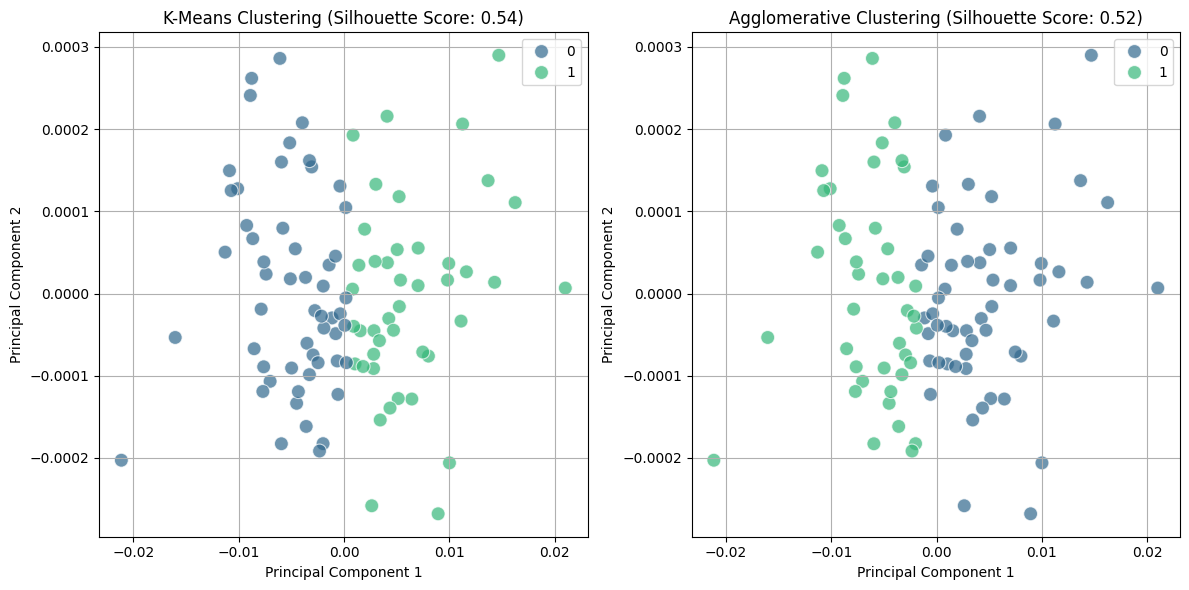

In [17]:
import os
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

def get_slopes(data):
    slopes = []
    x = np.arange(data.shape[0]).reshape(-1, 1)
    for i in range(data.shape[1]):
        y = data[:, i].reshape(-1, 1)
        if np.isnan(y).any():
            y = np.nan_to_num(y, nan=np.nanmean(y))
        model = LinearRegression()
        model.fit(x, y)
        slopes.append(model.coef_[0][0])
    return slopes

def cluster_files():
    data_dir = "D:\Projects\MLME_Test\Data"
    files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".txt")]

    if not files:
        print("No data files found in the directory.")
        return

    feature_vectors = []
    file_names = []

    for file_path in files:
        try:
            with open(file_path, 'r') as f:
                lines = f.readlines()
            
            lines = lines[1:]

            num_columns = -1
            for i, line in enumerate(lines):
                parts = line.strip().split('\t')
                if i == 0:
                    num_columns = len(parts)
                elif len(parts) != num_columns:
                    #print(f"Warning: Inconsistent number of columns in {os.path.basename(file_path)}. Skipping.")
                    continue

            data = np.genfromtxt(file_path, delimiter="\t", skip_header=1)
            
            if data.size == 0 or np.isnan(data).all():
                #print(f"Warning: Could not read data from {os.path.basename(file_path)}. Skipping.")
                continue

            feature_vector = get_slopes(data)

            if np.isnan(feature_vector).any():
                #print(f"Warning: NaN values in feature vector for {os.path.basename(file_path)}. Replacing with 0.")
                feature_vector = np.nan_to_num(feature_vector)

            feature_vectors.append(feature_vector)
            file_names.append(os.path.basename(file_path))

        except Exception as e:
            print(f"Error processing file {os.path.basename(file_path)}: {e}")

    if not feature_vectors:
        #print("No valid data to cluster.")
        return

    feature_vectors = np.array(feature_vectors)

    # --- K-Means Clustering ---
    kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
    kmeans_labels = kmeans.fit_predict(feature_vectors)
    kmeans_silhouette = silhouette_score(feature_vectors, kmeans_labels)

    # --- Agglomerative Clustering ---
    agg_clustering = AgglomerativeClustering(n_clusters=2)
    agg_labels = agg_clustering.fit_predict(feature_vectors)
    agg_silhouette = silhouette_score(feature_vectors, agg_labels)

    # --- PCA for Visualization ---
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(feature_vectors)

    # --- Plotting ---
    plt.figure(figsize=(12, 6))

    # K-Means Plot
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=kmeans_labels, palette='viridis', s=100, alpha=0.7)
    plt.title(f"K-Means Clustering (Silhouette Score: {kmeans_silhouette:.2f})")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)

    # Agglomerative Clustering Plot
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=agg_labels, palette='viridis', s=100, alpha=0.7)
    plt.title(f"Agglomerative Clustering (Silhouette Score: {agg_silhouette:.2f})")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("cluster_comparison.png")
    print("\nPlots saved to cluster_comparison.png")

    # --- Comparison Table ---
    df = pd.DataFrame({
        'File': file_names,
        'KMeans_Cluster': kmeans_labels,
        'Agglomerative_Cluster': agg_labels
    })

    print("\n--- Clustering Comparison Table ---")
    print(df.to_string())

if __name__ == "__main__":
    cluster_files()